In [26]:
!pip install lightning
!pip install pytorch-forecasting

In [27]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MASE, SMAPE, PoissonLoss, QuantileLoss


In [28]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [29]:
data_path = "/content/drive/MyDrive/Hitachi/Data/imputed_data.csv"

data_df = pd.read_csv(data_path)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Prices
(EUR/MWh)                27555 non-null  float64
 1   datetime                        27555 non-null  object 
 2   Demand (MW)                     27555 non-null  float64
 3   Temperature                     27555 non-null  float64
 4   feelslike                       27555 non-null  float64
 5   dewpoint                        27555 non-null  float64
 6   humidity                        27555 non-null  float64
 7   precipitation                   27555 non-null  float64
 8   precipprob                      27555 non-null  float64
 9   snow                            27555 non-null  float64
 10  snowdepth                       27555 non-null  float64
 11  windgust                        27555 non-null  float64
 12  windspeed                       

In [30]:
data_df.drop_duplicates(inplace=True)

In [7]:
data_df.sample(2)

,Prices\n(EUR/MWh),datetime,Demand (MW),Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,...,ice,rain,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow
27527,162.49,2023-02-20 20:00:00,498.0,51.2,51.2,38.0,60.64,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
23839,158.04,2022-09-20 05:00:00,572.2,73.1,73.1,70.1,90.15,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
data_df.columns

Index(['Prices\n(EUR/MWh)', 'datetime', 'Demand (MW)', 'Temperature',
       'feelslike', 'dewpoint', 'humidity', 'precipitation', 'precipprob',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddirection',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'uvindex', 'severerisk', 'freezingrain', 'ice', 'rain', 'snow.1',
       'Clear', 'Freezing Drizzle/Freezing Rain', 'Ice', 'Overcast',
       'Partially cloudy', 'Rain', 'Snow'],
      dtype='object')

In [9]:

# Make a column named time_idx with serial number ordering required
data_df['datetime'] = pd.to_datetime(data_df['datetime'])
data_df['time_idx'] = ((data_df['datetime'] - data_df['datetime'].min()).dt.total_seconds() / 3600).apply(lambda x:int(x))

# Display the result
print(data_df.time_idx)


0            0
1            1
2            2
3            3
4            4
         ...  
27550    27547
27551    27548
27552    27549
27553    27550
27554    27551
Name: time_idx, Length: 27555, dtype: int64


In [10]:
# we want to encode special conditions as one variable and thus need to first reverse one-hot encoding
special_conditions = ['freezingrain',
                      'ice',
                      'rain',
                      # 'snow.1',
                      'Clear',
                      'Freezing Drizzle/Freezing Rain',
                      'Ice',
                      'Overcast',
                      'Partially cloudy',
                      'Rain',
                      'Snow',
]
data_df[special_conditions] = data_df[special_conditions].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data_df.sample(10, random_state=521)

,Prices\n(EUR/MWh),datetime,Demand (MW),Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,...,rain,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow,time_idx
9442,46.67,2021-01-28 09:00:00,652.1,24.2,18.2,12.8,61.48,0.0,0.0,0.0,...,-,0,Clear,-,-,-,-,-,-,9441
7547,22.74,2020-11-10 10:00:00,597.4,74.0,74.0,60.2,61.96,0.0,0.0,0.0,...,-,0,-,-,-,Overcast,-,-,-,7546
20078,109.19,2022-04-16 12:00:00,392.9,57.8,57.8,43.1,57.83,0.0,0.0,0.0,...,-,0,Clear,-,-,-,-,-,-,20076
23648,273.70,2022-09-12 06:00:00,545.4,55.1,55.1,53.1,92.75,0.0,0.0,0.0,...,-,0,Clear,-,-,-,-,-,-,23646
13284,124.45,2021-07-07 11:00:00,813.9,86.0,89.4,68.0,55.08,0.0,0.0,0.0,...,-,0,Clear,-,-,-,-,-,-,13283
18594,382.72,2022-02-13 16:00:00,517.9,32.0,24.8,17.1,53.66,0.0,0.0,0.0,...,-,0,-,-,-,-,Partially cloudy,-,-,18592
11476,47.00,2021-04-23 03:00:00,421.9,45.0,45.0,33.2,63.10,0.0,0.0,0.0,...,-,0,-,-,-,-,Partially cloudy,-,-,11475
27431,36.58,2023-02-16 20:00:00,529.0,38.9,30.8,32.0,75.94,0.0,0.0,0.0,...,-,0,-,-,-,Overcast,-,-,-,27428
10330,58.16,2021-03-06 09:00:00,480.6,43.1,38.3,20.9,40.96,0.0,0.0,0.0,...,-,0,Clear,-,-,-,-,-,-,10329
5936,33.48,2020-09-04 08:00:00,593.4,66.8,66.8,51.2,57.13,0.0,0.0,0.0,...,-,0,Clear,-,-,-,-,-,-,5936


In [11]:
data_df.describe()

,Prices\n(EUR/MWh),Demand (MW),Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,...,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,snow.1,time_idx
count,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,...,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000
mean,139.687663,551.811787,56.874894,55.534582,45.511448,68.487612,0.005641,6.927962,0.001211,0.044494,...,6.481105,158.313090,1018.027044,39.773001,9.179258,163.645048,1.614589,13.108420,0.011359,13775.760588
std,132.312714,114.435250,18.765977,21.594238,18.231295,18.202928,0.044919,25.393365,0.041323,0.378753,...,4.743448,120.246949,6.657668,44.947591,1.909876,265.485397,2.663094,8.109972,0.105974,7953.682835
min,-35.000000,320.000000,-5.900000,-30.100000,-14.900000,17.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,991.900000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,43.785000,474.500000,42.200000,38.000000,29.900000,55.145000,0.000000,0.000000,0.000000,0.000000,...,3.400000,30.000000,1013.900000,0.000000,9.900000,0.000000,0.000000,10.000000,0.000000,6888.500000
50%,84.110000,529.500000,56.900000,56.900000,46.100000,70.540000,0.000000,0.000000,0.000000,0.000000,...,5.800000,180.000000,1017.500000,0.000000,9.900000,12.000000,0.000000,13.108420,0.000000,13776.000000
75%,203.175000,601.900000,72.000000,72.000000,62.100000,83.960000,0.000000,0.000000,0.000000,0.000000,...,9.200000,260.000000,1022.300000,100.000000,9.900000,222.000000,2.000000,13.108420,0.000000,20663.500000
max,1047.100000,1020.200000,99.000000,110.400000,79.100000,100.000000,2.376000,100.000000,4.700000,5.780000,...,38.000000,360.000000,1041.500000,100.000000,34.900000,1197.000000,10.000000,100.000000,1.000000,27551.000000


In [13]:
data_df = data_df.drop('snow.1', axis=1)

In [14]:
max_prediction_length = 24
max_encoder_length = 24
training_cutoff = data_df["time_idx"].max() - max_prediction_length

data_df['group'] = 0 #Required below to denote single group of data

training = TimeSeriesDataSet(
    data_df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Demand (MW)",
    group_ids=['group'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_conditions"],
    variable_groups={"special_conditions": special_conditions},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", 'Temperature',
       'feelslike', 'dewpoint', 'humidity', 'precipitation', 'precipprob',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddirection',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'uvindex', 'severerisk'],
    allow_missing_timesteps=True,
    target_normalizer=GroupNormalizer(
        groups=["group"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data_df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [15]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

tensor(32.0083, device='cuda:0')

In [16]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 20.7k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.07943282347242808
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.07943282347242808
INFO: Restoring states from the checkpoint path at /content/.lr_find_c80925f6-de8d-445b-9585-e867679d9729.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_c80925f6-de8d-445b-9585-e867679d9729.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_c80925f6-de8d-445b-9585-e867679d9729.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_c80925f6-de8d-445b-9585-e867679d9729.ckpt


suggested learning rate: 0.07943282347242808


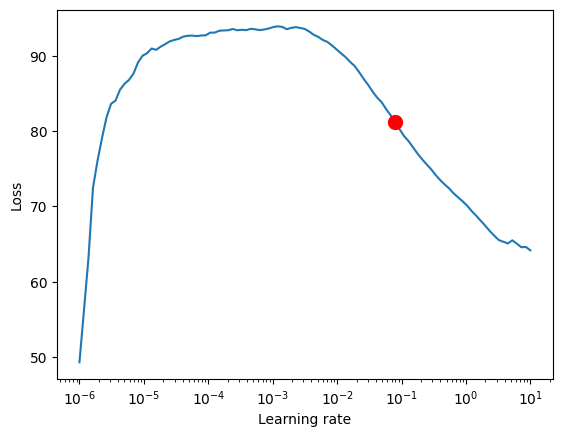

In [17]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [31]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("/content/drive/MyDrive/Hitachi/Nishant/new/")   # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.p

Number of parameters in network: 43.3k


In [32]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 66    
3  | prescalers                         | ModuleDict                      | 352   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 13.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = '/content/drive/MyDrive/Hitachi/Nishant/lightning_logs/version_2/checkpoints/epoch=24-step=1250.ckpt'
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
best_model_path

'/content/drive/MyDrive/Hitachi/Nishant/lightning_logs/version_2/checkpoints/epoch=24-step=1250.ckpt'

In [23]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


tensor(12.6576)

In [24]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


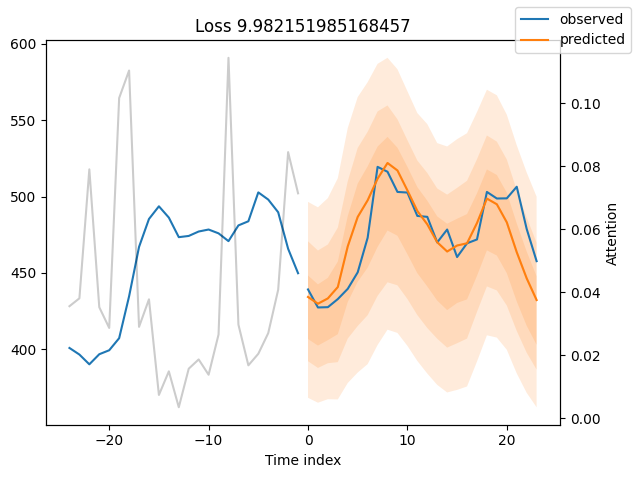

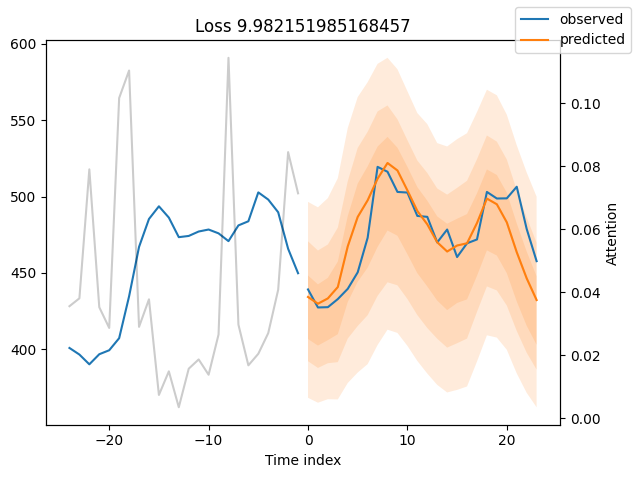

In [25]:
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Demand (MW)_center': <Figure size 1000x500 with 2 Axes>,
 'Demand (MW)_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'Temperature': <Figure size 1000x500 with 2 Axes>,
 'feelslike': <Figure size 1000x500 with 2 Axes>,
 'dewpoint': <Figure size 1000x500 with 2 Axes>,
 'humidity': <Figure size 1000x500 with 2 Axes>,
 'precipitation': <Figure size 1000x500 with 2 Axes>,
 'precipprob': <Figure size 1000x500 with 2 Axes>,
 'snow': <Figure size 1000x500 with 2 Axes>,
 'snowdepth': <Figure size 1000x500 with 2 Axes>,
 'windgust': <Figure size 1000x500 with 2 Axes>,
 'windspeed': <Figure size 1000x500 with 2 Axes>,
 'winddirection': <Figure size 1000x500 with 2 Axes>,
 'sealevelpressure': <Figure size 1000x500 with 2 Axes>,
 'cloudcover': <Figure size 1000x500 with 2 Axes>,
 'visibility': <Figure size 1000x500 with 2 Axes>,
 'solarradiation': <Figure size 1000x500 with 2 Axes>,
 'uvindex': 

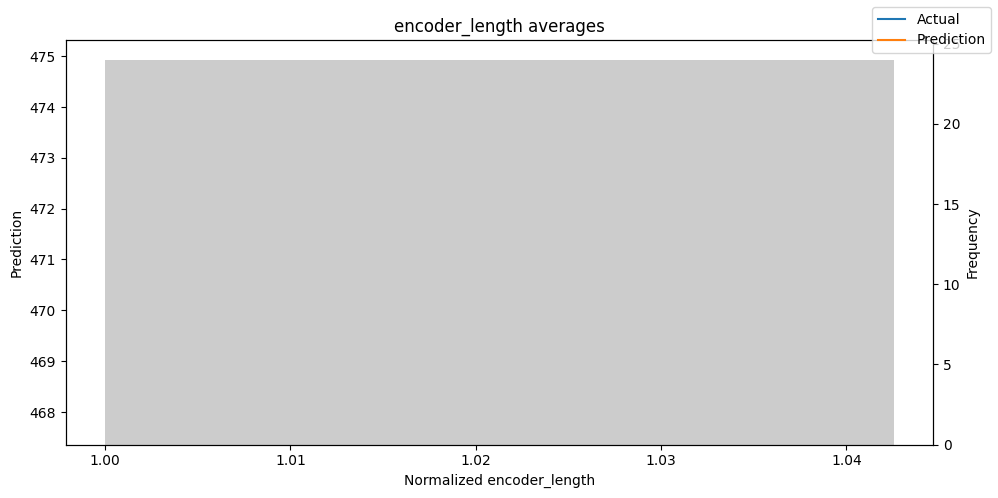

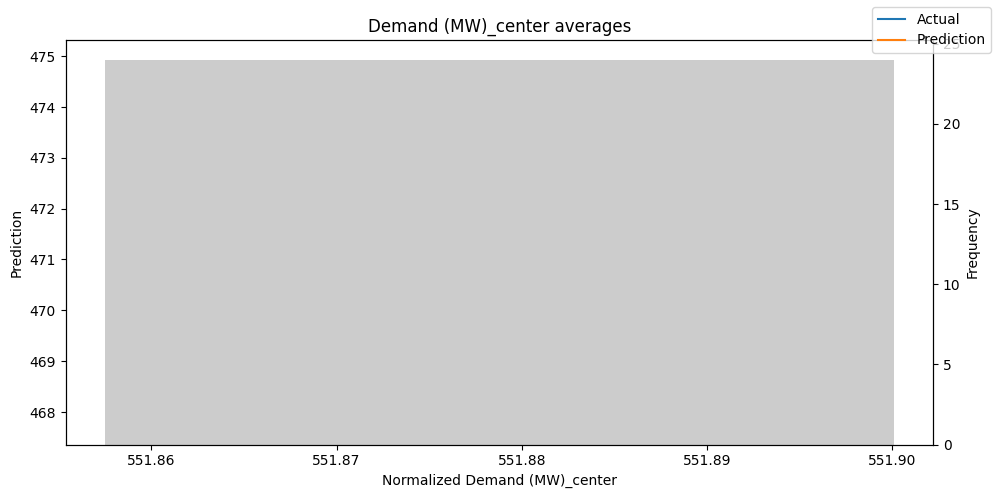

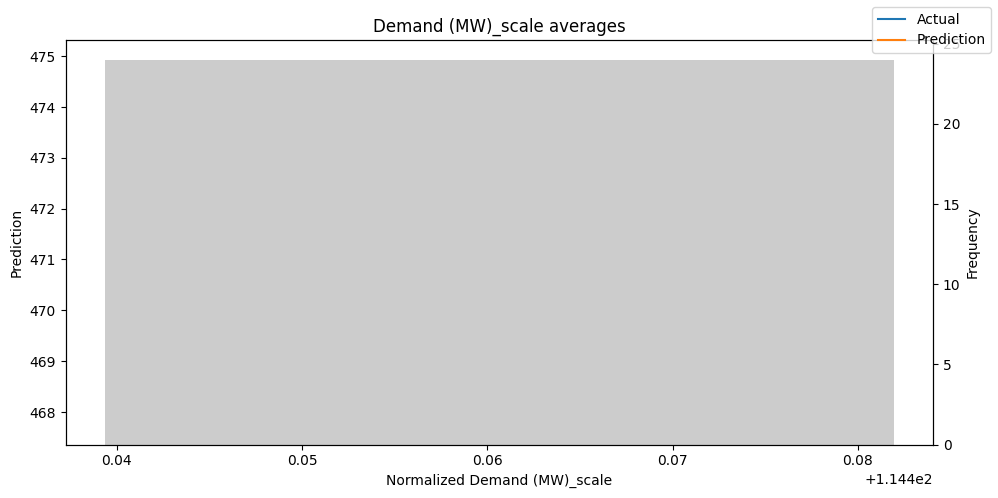

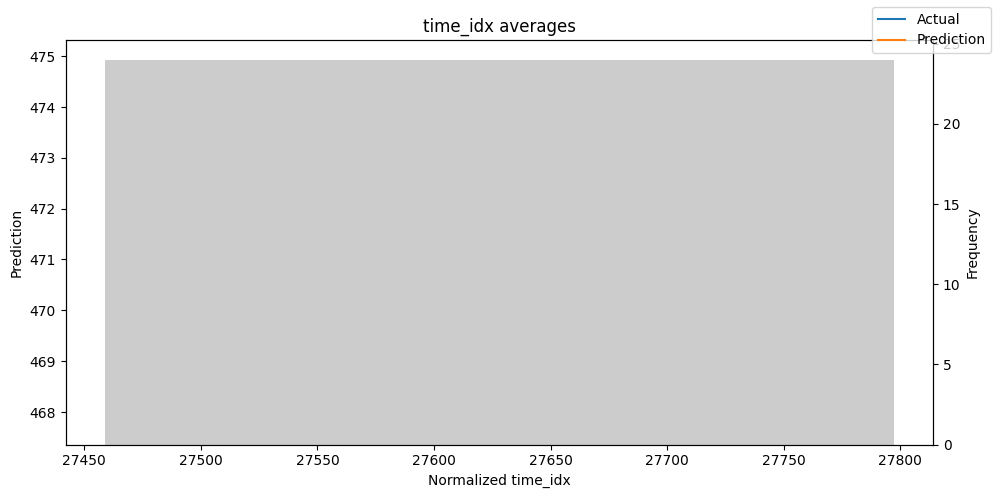

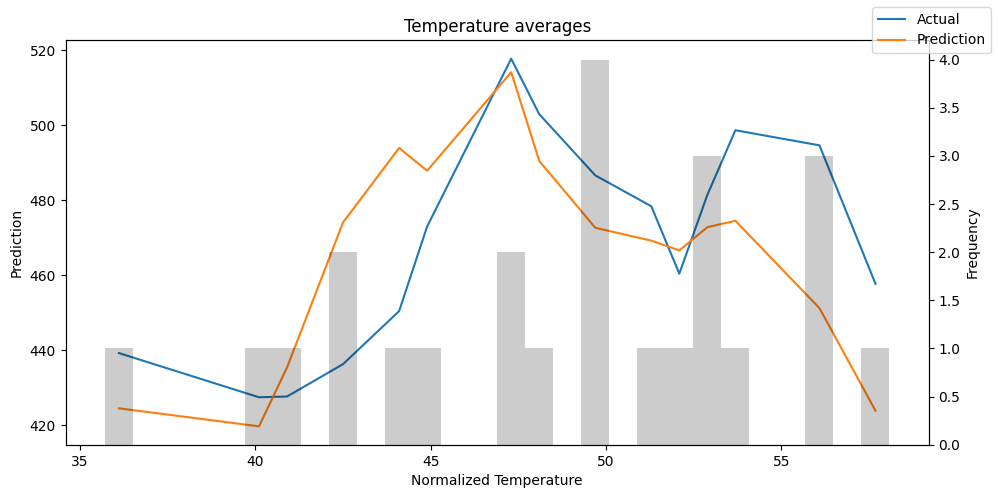

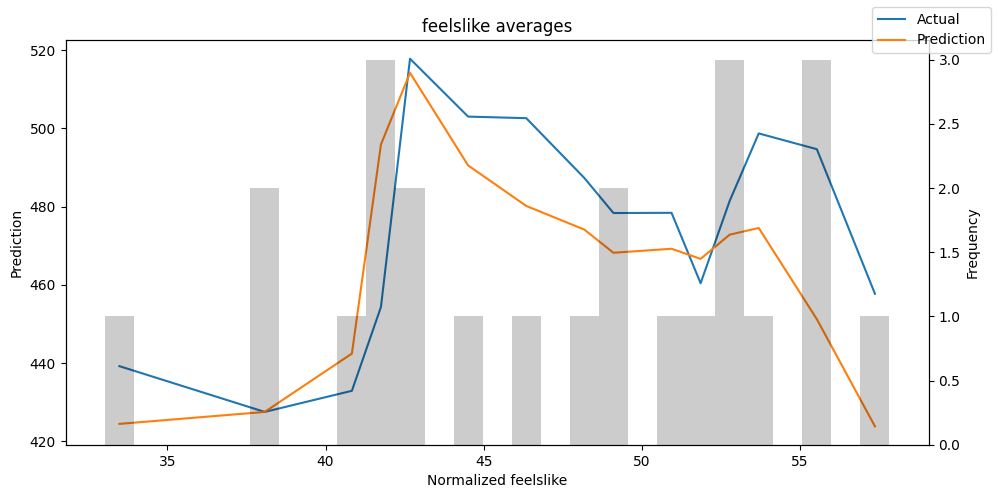

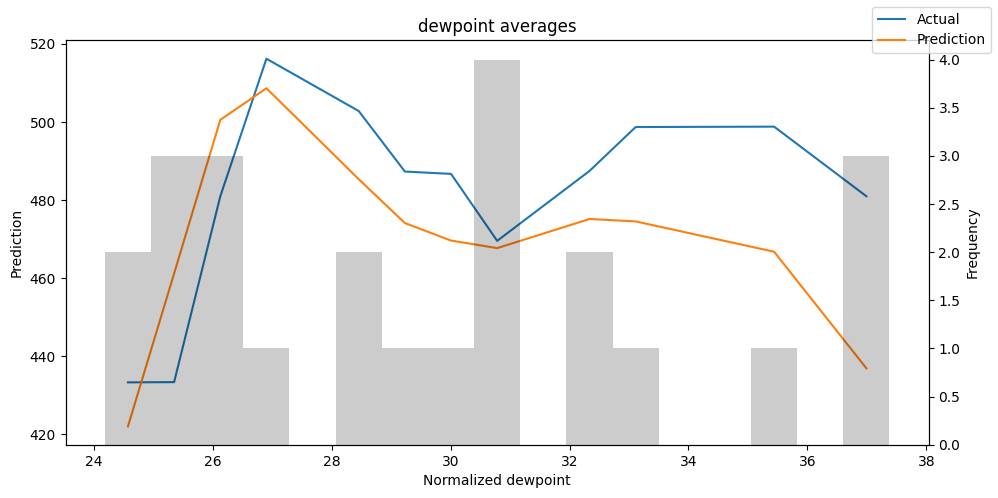

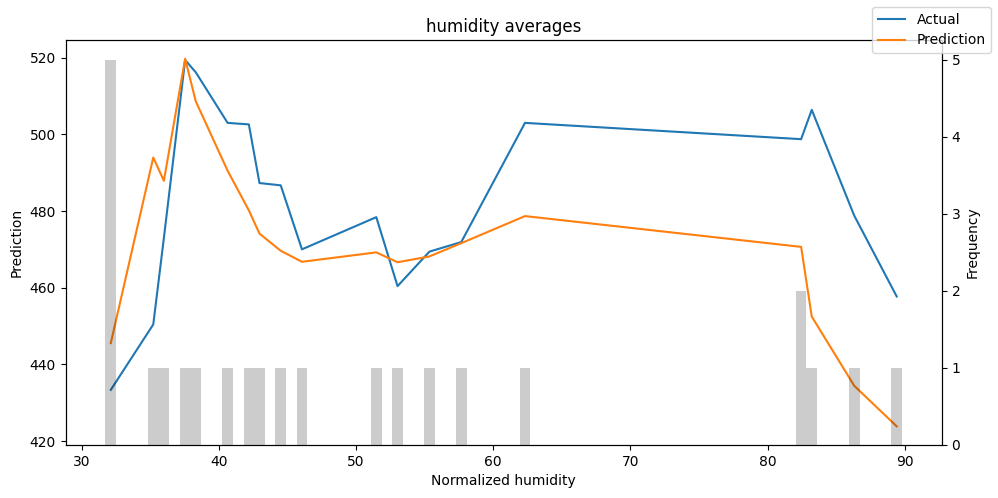

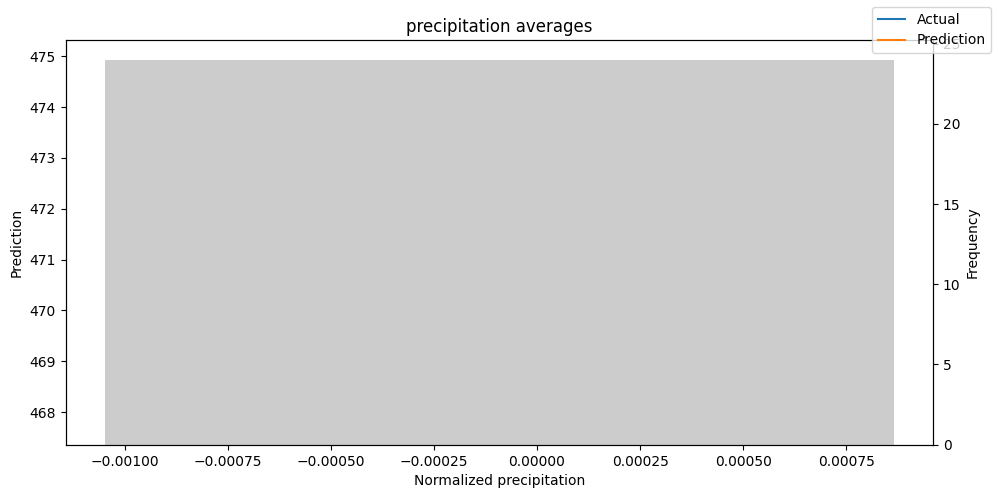

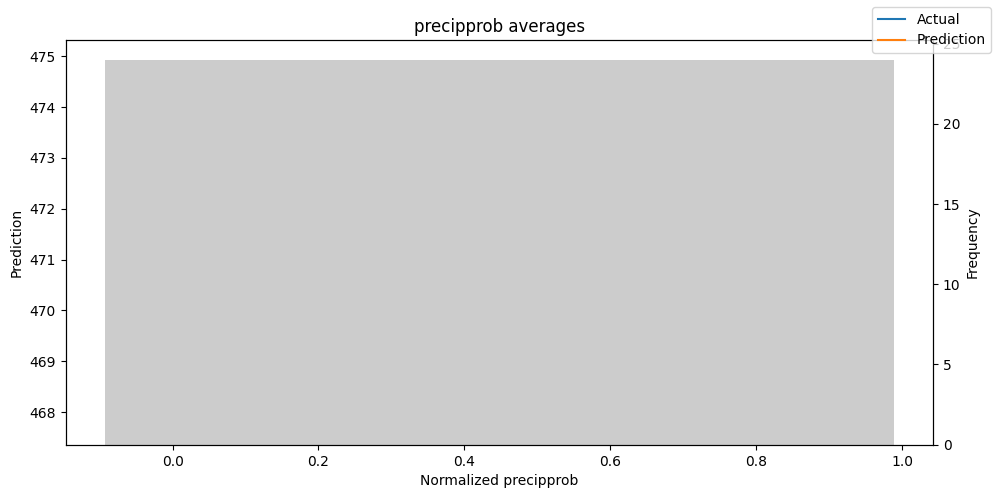

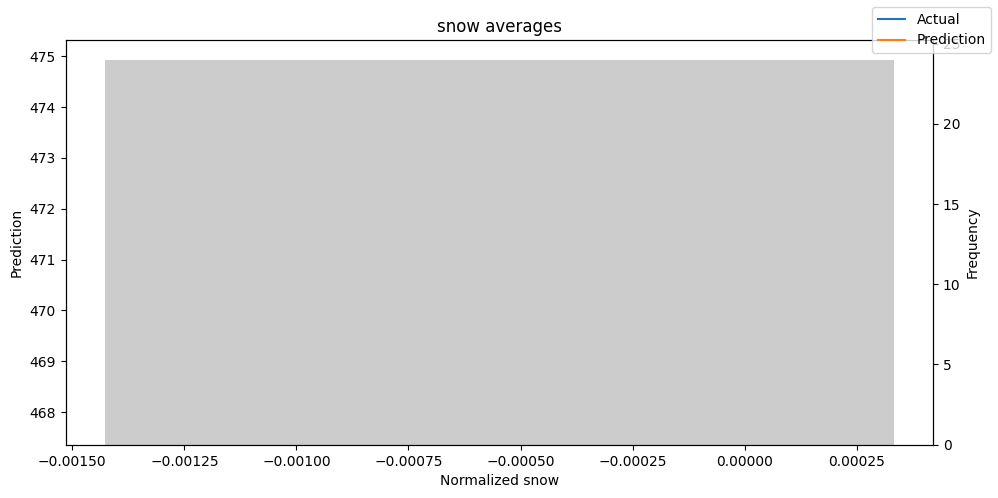

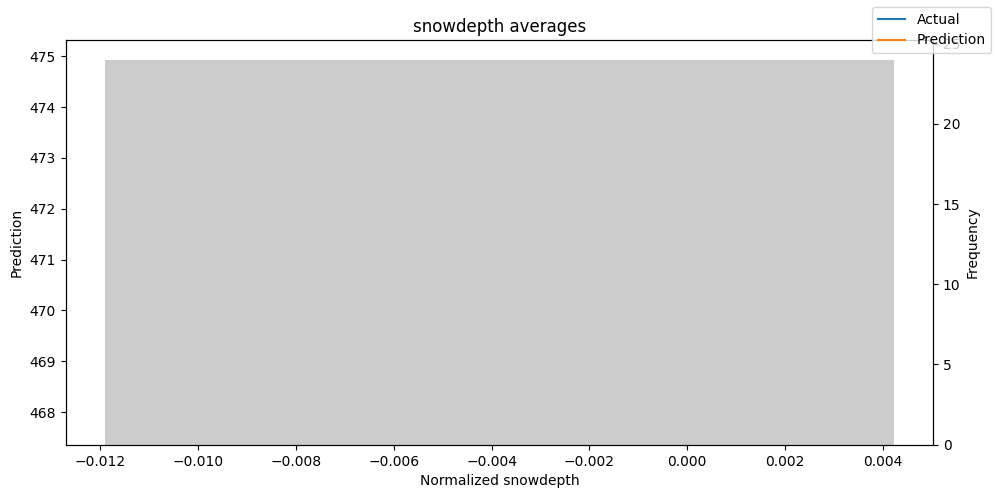

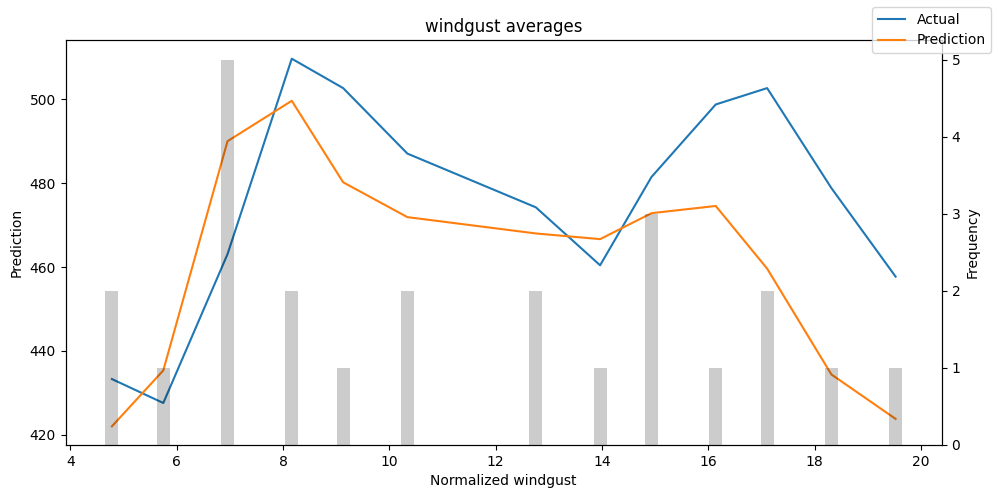

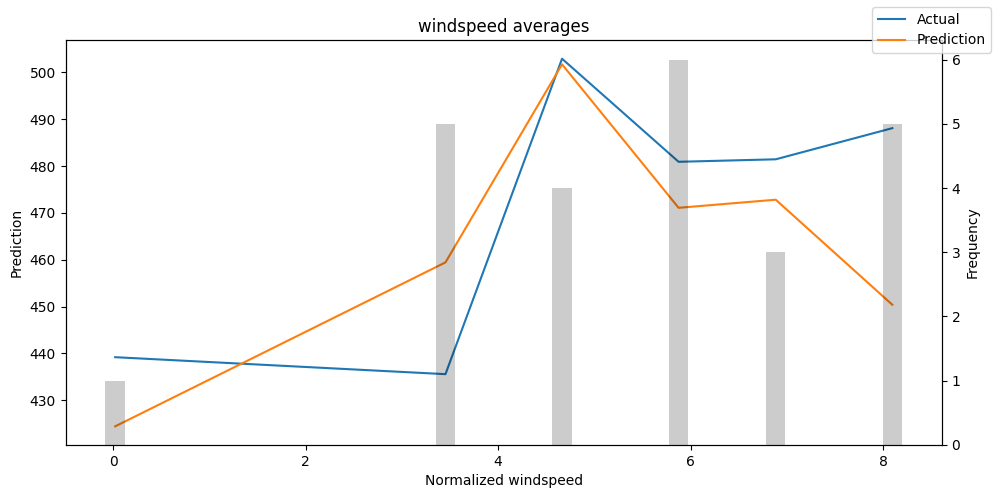

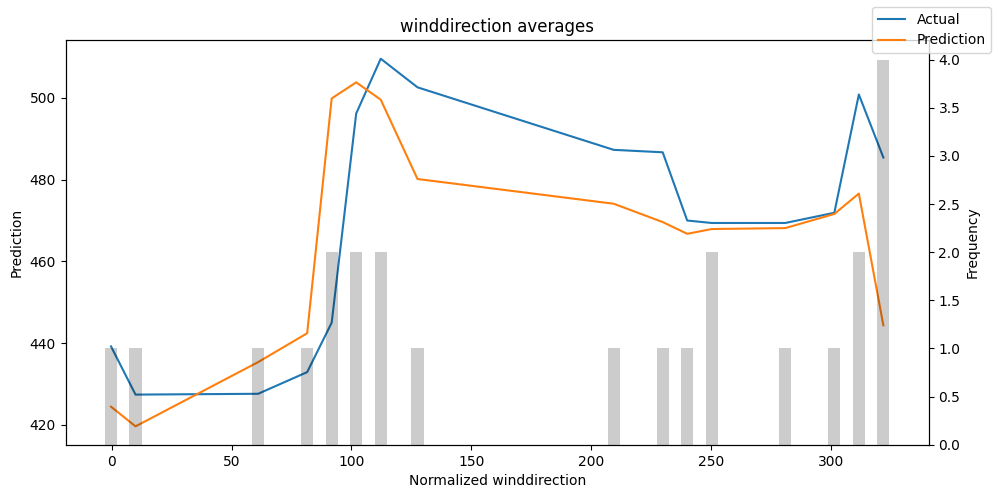

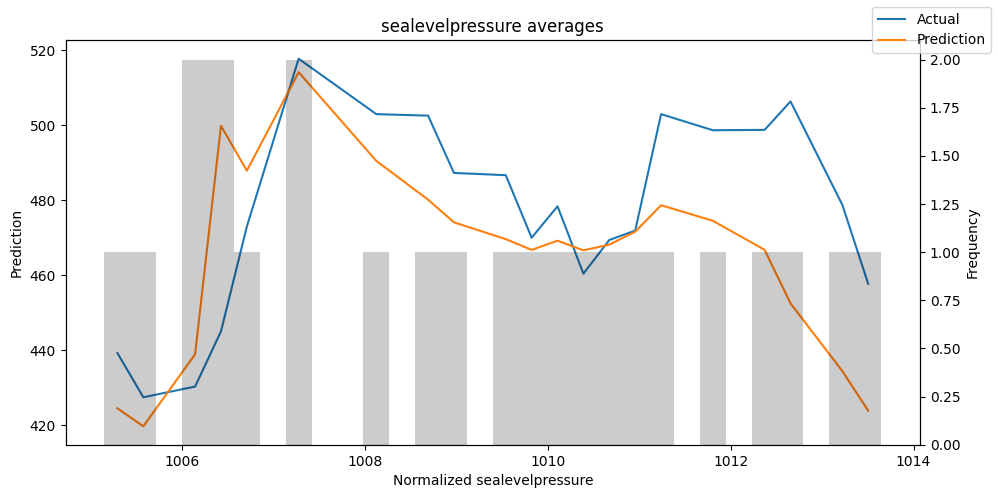

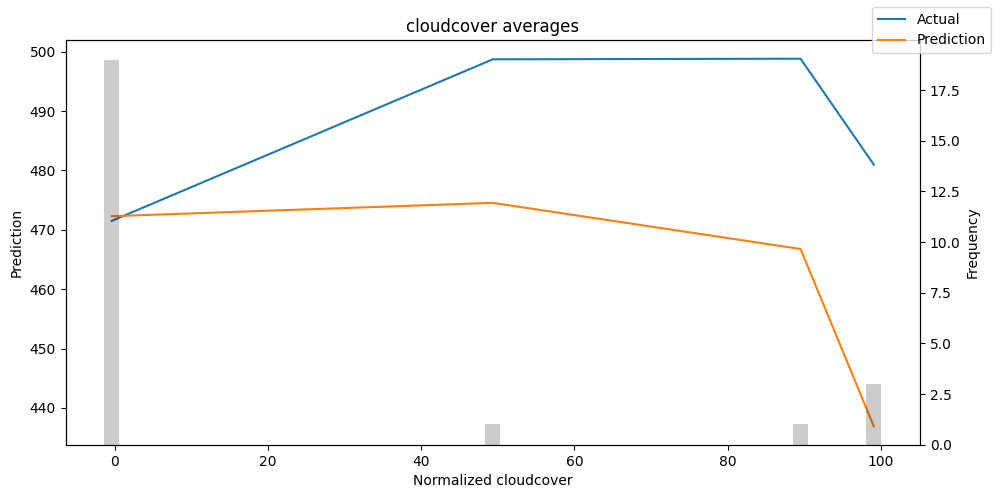

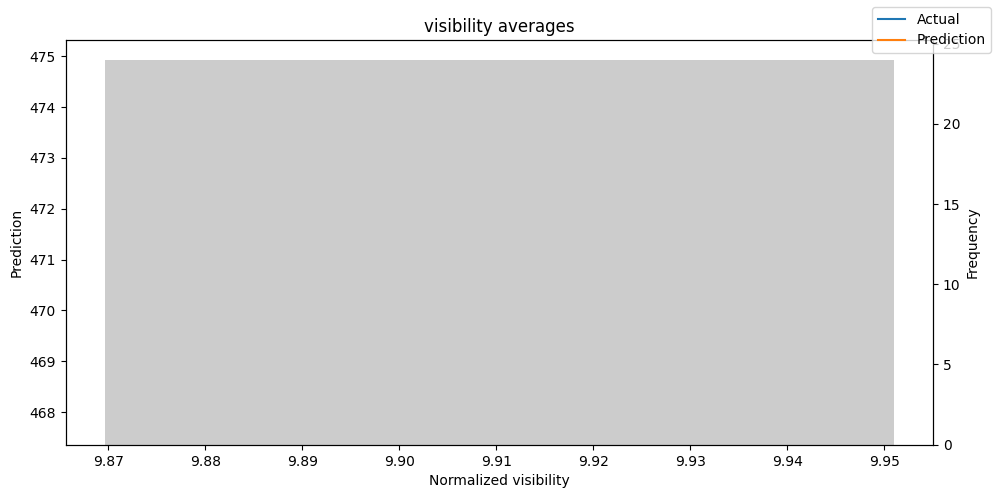

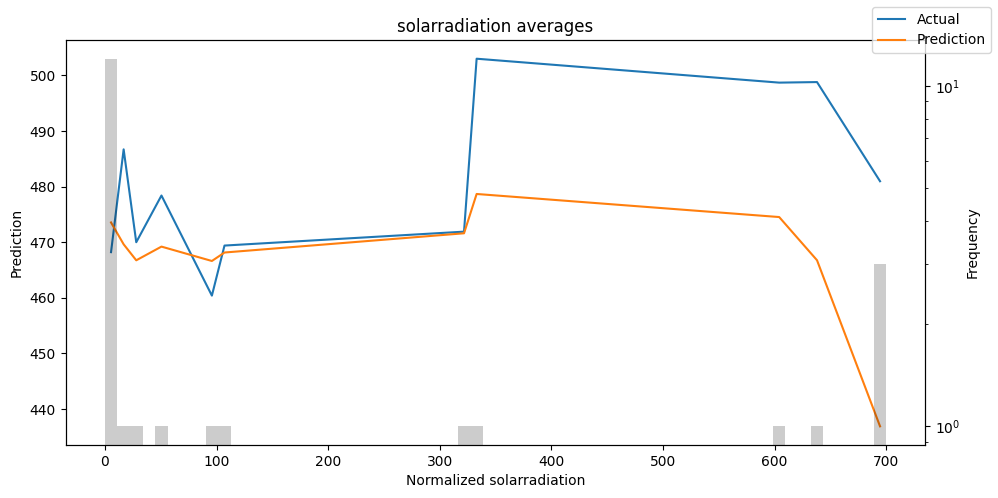

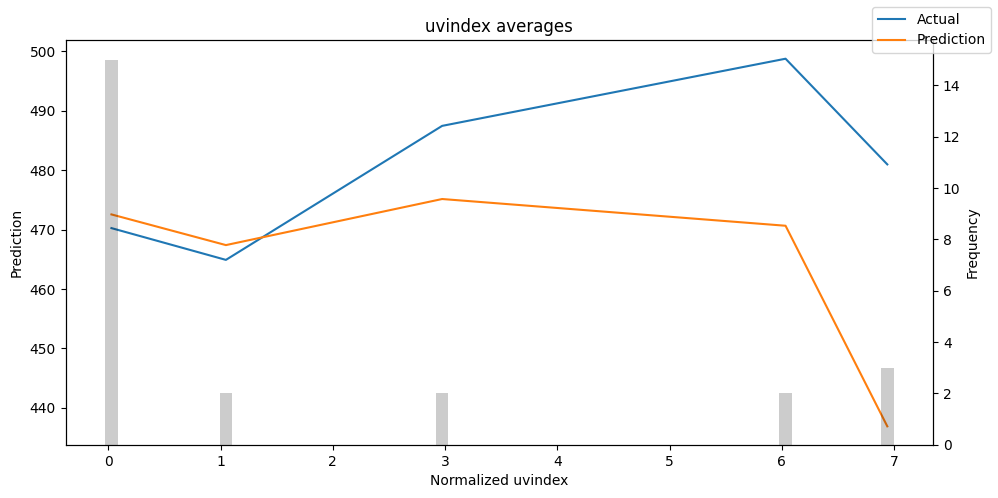

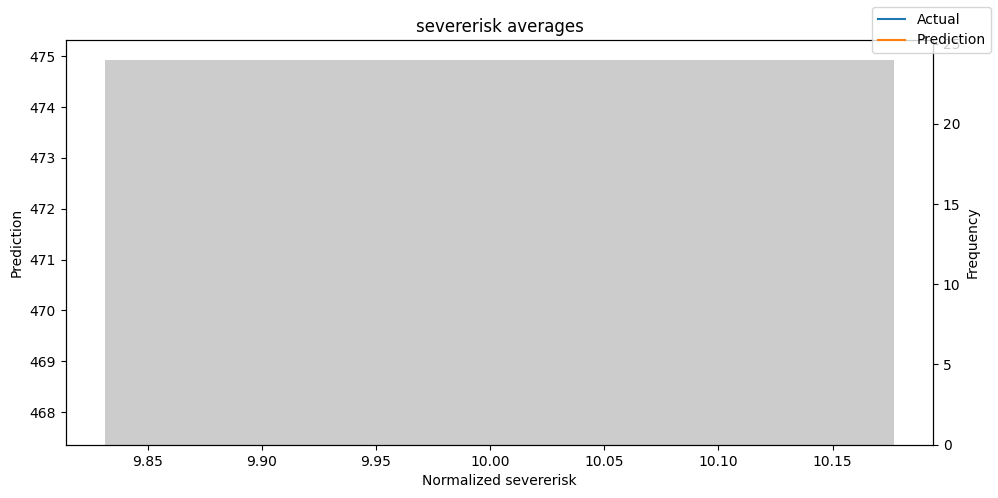

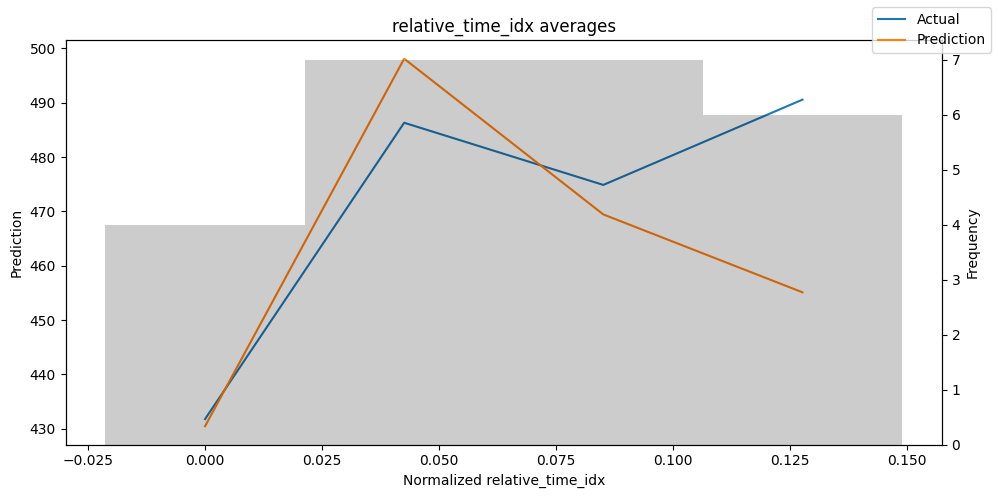

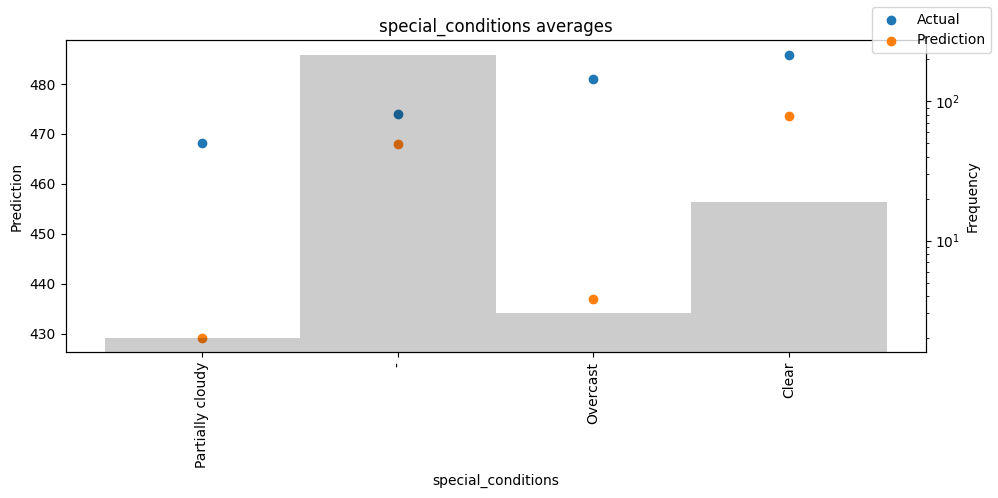

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)